In [1]:
import os
import sys
import itertools as itt

# File reading
from pathlib import Path
import czifile as czi
import tifffile as tiff

# Image preprocessing
import cv2
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects


# Calculations
from scipy import ndimage as ndi
import numpy as np

# Analysis
import astrobject as ao
import ccdb
import astromorpho as astro
import ucats

# Viewing
import napari
import matplotlib.pyplot as plt
%matplotlib inline

# Beauty
from tqdm.auto import tqdm

# Utils
from importlib import reload

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-10-11 19:21:26.982781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-10-11 19:21:26.982804: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [3]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["black", "red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

# Параметры для запуска

In [65]:
if os.path.exists('/home/levtg/astro-morpho'):
    data_dir = '/home/levtg/astro-morpho/data/popov_morph/'
else:
    print("Dont know where to look for the data")

output_dir = '/home/levtg/astro-morpho/data/popov_morph/output/'

filename = 'T4_.tif'

use_clahe = True
sigmas = 2**np.arange(0, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

USE_NAPARI = True

# Set false to start from console
HANDY = True

# Set true to save output
OUT = True

# Считывание изображения

In [66]:
if HANDY:
    VERBOSE = True

In [67]:
datapath = Path(data_dir).joinpath(filename)
# datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/levtg/astro-morpho/data/popov_morph/T4_.tif')

In [68]:
# tifname = Path(str(datapath)[:-3] + 'tif')

# if tifname.exists():
#     stack = tiff.imread(tifname)
# else:
#     raise Exception('ALARM!!!')
# # else:
# #     czi.czi2tif(datapath, tiffile=tifname)
# #     stack = tiff.imread(tifname)[2]
# stack.shape

In [69]:
stack = tiff.imread(datapath)

In [70]:
stack.shape

(50, 512, 512)

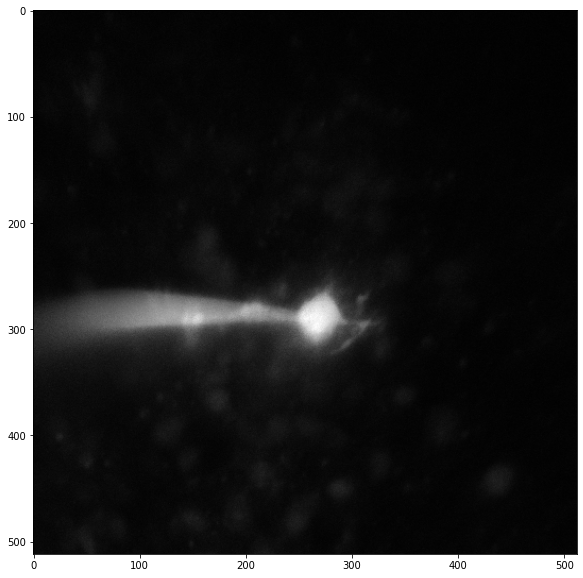

In [71]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(stack, ndisplay=3, opacity=0.5)
    else:
        imgplot = plt.imshow(np.sum(stack, axis=0))
        plt.show()

# Удаление пипетки

In [73]:
import pipette_segmentation as ps

In [74]:
image = stack

In [75]:
simple_mask = ps.make_simple_mask(image)
sato_mask = ps.make_sato_mask(image)
masks3 = ps.combine_masks(image, simple_mask, sato_mask)

vx = masks3.sum(axis=(1,2))
vx_sato = ps.st_roll(sato_mask).sum(axis=(1,2))

try:
    kink = ps.find_kink(vx)
except :
    #print(E)
    kink = len(vx)

masks3a = masks3.copy()
masks3a[kink:]=0
masks3a = ucats.masks.largest_region(masks3a)

  0%|          | 0/5 [00:00<?, ?it/s]

thresholds 0.0776519406237158 0.07967152943145209 0.15934305886290417
52


In [76]:
use_kink = True

In [77]:

masks3_final = masks3a if use_kink else masks3
masks3_final = np.moveaxis(masks3_final,0,2)

show_stack = (stack*(~(ndi.binary_dilation(masks3_final,iterations=3)))).astype(np.float64)

In [78]:
show_stack.shape

(50, 512, 512)

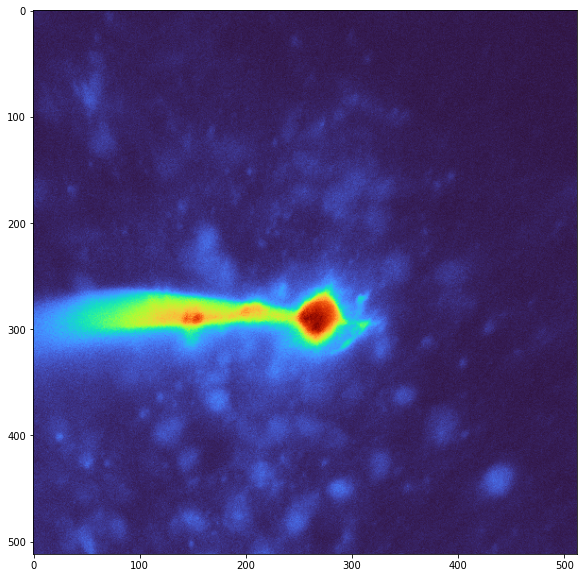

In [79]:
if VERBOSE:
    if USE_NAPARI:
        napari.view_image(show_stack)
    else:
        imgplot = plt.imshow(np.sum(show_stack, axis=0), cmap='turbo')
        plt.show()

# Предобработка изображения

In [80]:
# clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))

In [81]:
# image = show_stack
# stack_shape = image.shape
# img_clahe = np.zeros(image.shape, np.float32)
# for k, plane in enumerate(image):
#     img_clahe[k] = clahe.apply(plane.astype('uint8'))

In [82]:
# if VERBOSE:
#     imgplot = plt.imshow(np.sum(img_clahe, axis=0))
#     plt.show()

In [83]:
# if VERBOSE:
#     i = 14
#     fig, axs = plt.subplots(7,7, figsize=(12,21))
#     for ax, pic in zip(np.ravel(axs), img_clahe[i:i+49]):
#         ax.imshow(pic)

# Фильтрация изображения

In [84]:
def largest_region(mask):
    labels, nlab = ndi.label(mask)
    if nlab > 0:
        objs = ndi.find_objects(labels)
        sizes = [np.sum(labels[o]==k+1) for k,o in enumerate(objs)]
        k = np.argmax(sizes)
        return labels==k+1
    else:
        return mask

In [85]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    #img_filt = np.where(image > threshold, image, 0)
    pre_mask = ndi.binary_closing(image >= threshold)
    pre_mask = remove_small_objects(pre_mask, 5, connectivity=3)
    binary_clean = largest_region(pre_mask)
    return np.where(binary_clean, image, 0)

In [86]:
img = show_stack

In [87]:
clean_img = filter_image(img, threshold_li)

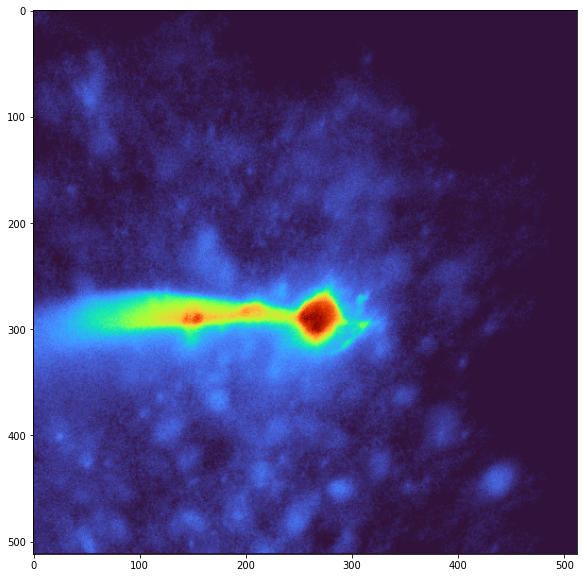

In [88]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(show_image, opacity=0.5) 
        w.add_image(clean_img, blending='additive')
    else:
        show_image = np.sum(clean_img, axis=0)
        imgplot = plt.imshow(show_image, cmap='turbo')
        plt.show()

# Анализ

In [89]:
obj = ao.AstrObject(clean_img)
print('Center')
obj.center_detection()
obj.center

Center


(38, 286, 187)

In [90]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5)
        w.add_points(*obj.center)
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image, cmap='turbo')
        plt.scatter(*obj.center[:0:-1], c='r')
        plt.show()

In [91]:
print('Soma Mask')
%time obj.soma_segmentation(return_shell=True)

Soma Mask
Mask Expanding
Soma Shell
CPU times: user 1min 10s, sys: 71 ms, total: 1min 10s
Wall time: 1min 10s


In [92]:
obj.soma_mask.shape

(50, 512, 512)

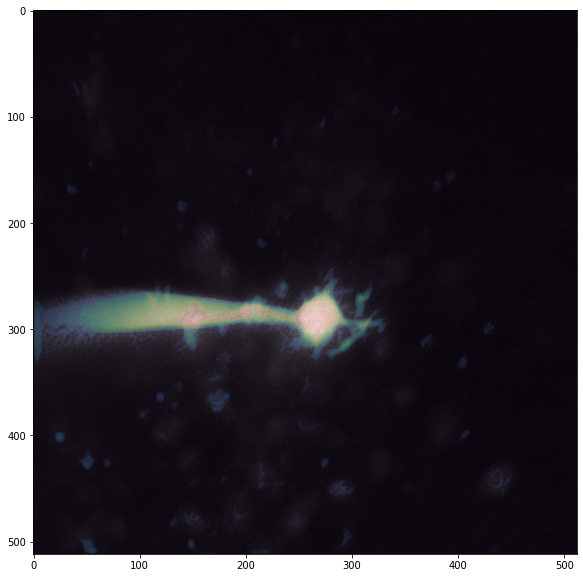

In [104]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5)
        w.add_image(obj.sigma_mask, blending='additive', colormap='turbo')
    else:
        show_image = np.sum(img, axis=0)
        imgplot = plt.imshow(show_image)
        plt.imshow(np.sum(obj.sigma_mask, axis=0), cmap='turbo', alpha=0.2)
        plt.show()

In [95]:
print('Branch Segmentation')
%time obj.branch_segmentation((1,), sigmas=sigmas)

Branch Segmentation
Vectors...


Calculating:   0%|          | 0/6 [00:00<?, ?it/s]

Masks and sigmas cleaning...
Merging...
CPU times: user 2min 4s, sys: 10.7 s, total: 2min 15s
Wall time: 39 s


In [96]:
print('Full Graph')
%time obj.full_graph_plotting(alpha, beta)

Full Graph


Edge calculation:   0%|          | 0/13 [00:00<?, ?it/s]

Preventing "jumps":   0%|          | 0/1017616 [00:00<?, ?it/s]

CPU times: user 47.1 s, sys: 3.77 s, total: 50.8 s
Wall time: 50.9 s


In [97]:
print('Graph')
%time obj.astro_graph_plotting(loneliness=0)
graph = obj.graph

Graph
scaling sequential paths...


  0%|          | 0/6 [00:00<?, ?it/s]

compose path segments...


  0%|          | 0/164 [00:00<?, ?it/s]

No cycles!
gx_all 913
<class 'astro_graph.AstroGraph'>
CPU times: user 48.1 s, sys: 6.98 ms, total: 48.1 s
Wall time: 48.2 s


In [98]:
# plt.imshow(np.sum(obj.sigma_mask, axis=0), cmap='turbo')

In [99]:
test_image = np.zeros(img.shape)
points = np.array(list(graph.nodes))
test_image[points[:,0], points[:,1], points[:,2]] = 1

In [100]:
sum_img = np.sum(test_image, axis=0)

In [101]:
sum_img[sum_img.astype(bool)] = 1

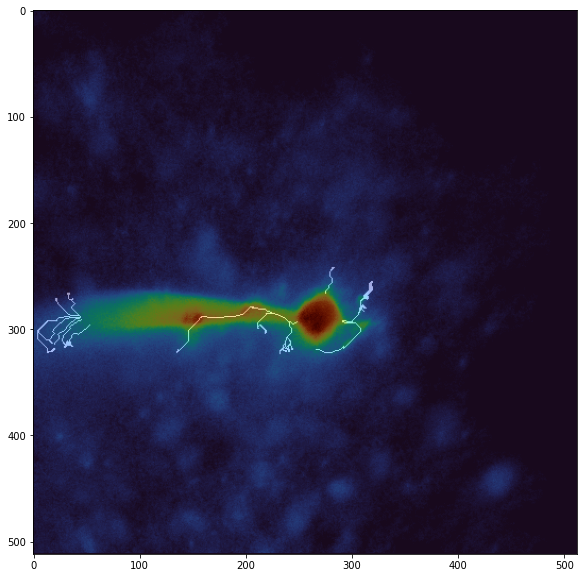

In [102]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image)
        obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)
    else:
        show_image = np.sum(obj.image, axis=0)
        plt.imshow(show_image, cmap='turbo')
        plt.imshow(sum_img, alpha=0.5)
        plt.savefig(filename[:-3])

# Сохранение

In [ ]:
# Пока не работает

In [133]:
# import astrocyte
# import pickle

# if OUT:
#     pickle_name = os.path.join(output_dir, str(filename) + '.pickle')
#     %time pickle.dump(obj.graph, open(pickle_name, 'wb'))

AttributeError: Can't pickle local object 'subgraph_view.<locals>.reverse_edge'